In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertModel, BertTokenizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
train_df=pd.read_csv(r"/kaggle/input/unsw-nb15/UNSW_NB15_train.csv")
test_df=pd.read_csv(r"/kaggle/input/unsw-nb15/UNSW_NB15_test.csv")

In [3]:
train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [4]:
train_df.shape

(175341, 45)

In [5]:
test_df.shape

(82332, 45)

In [6]:
print("Missing Values in Train Dataset:\n", train_df.isnull().sum())
print("\nMissing Values in Test Dataset:\n", test_df.isnull().sum())

Missing Values in Train Dataset:
 id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0


In [7]:
duplicates=train_df.duplicated()
duplicates[duplicates==True]

Series([], dtype: bool)

In [8]:
# Remove duplicates from both train and test datasets
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

# Display the new shape after duplicate removal
print("Train Dataset Shape After Removing Duplicates:", train_df.shape)
print("Test Dataset Shape After Removing Duplicates:", test_df.shape)

Train Dataset Shape After Removing Duplicates: (175341, 45)
Test Dataset Shape After Removing Duplicates: (82332, 45)


In [9]:
numerical_cols = [col for col in train_df.columns if train_df[col].dtype in ['int64', 'float64']]

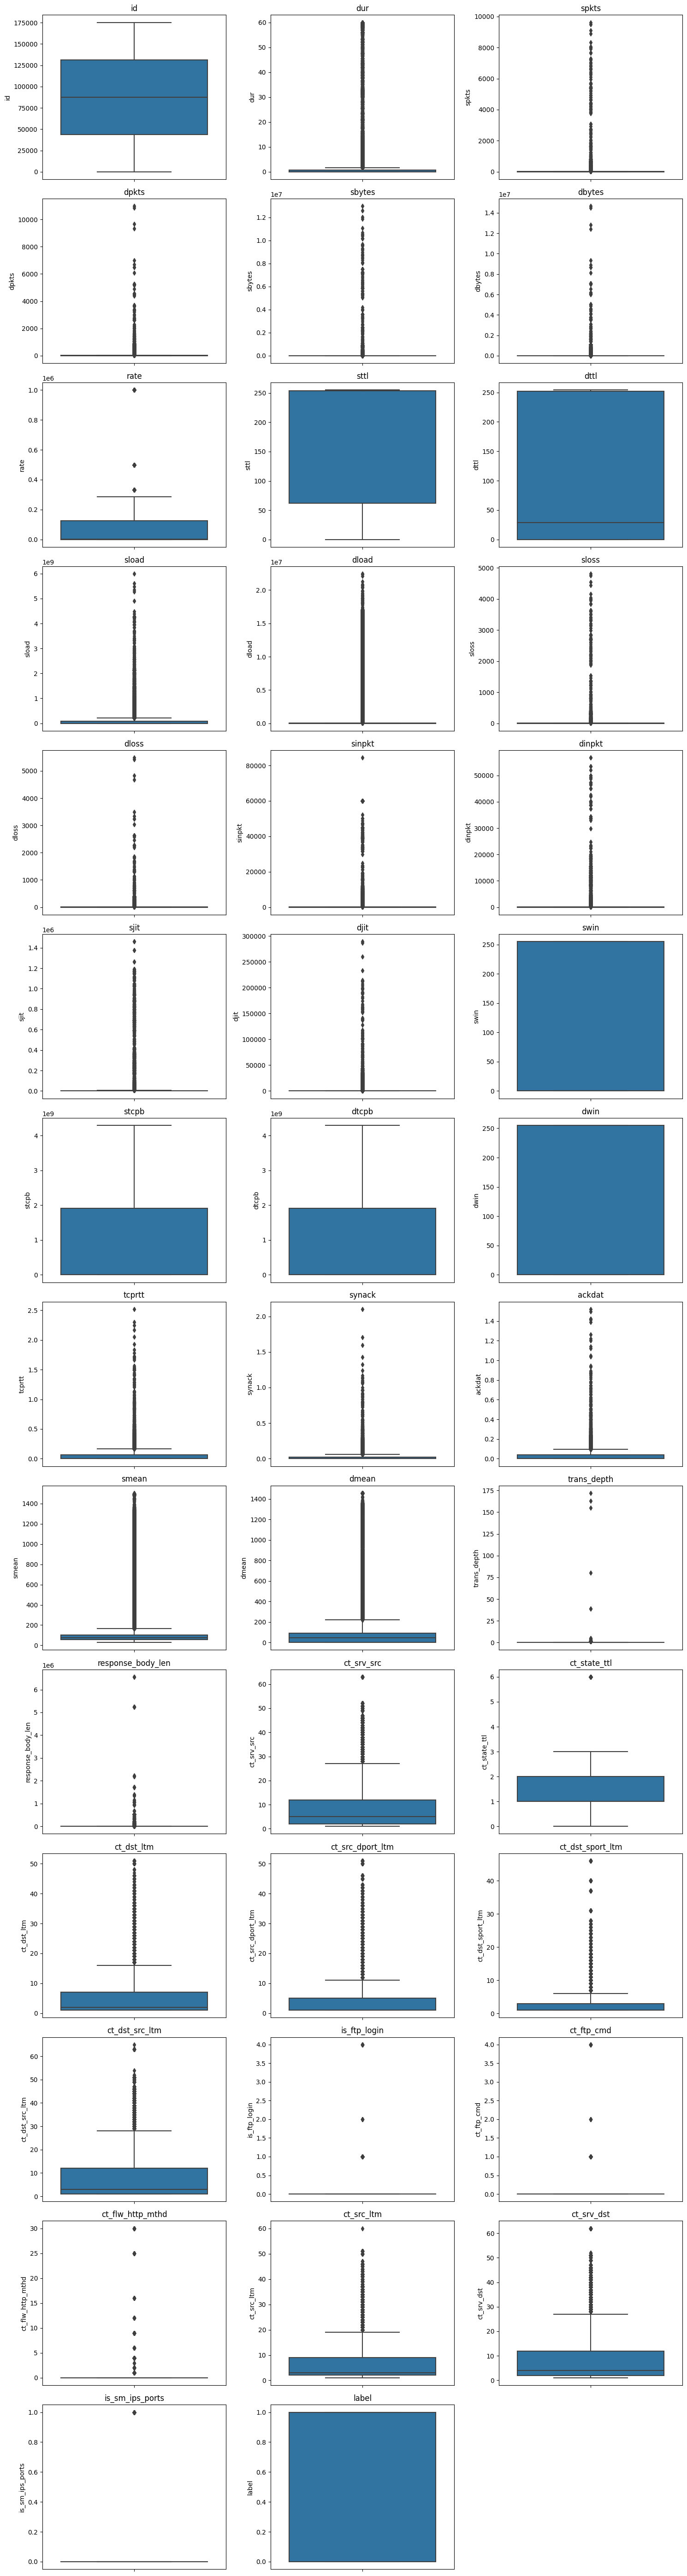

In [10]:
# Define the number of columns per row
import seaborn as sns
num_cols = 3  # Change this based on your dataset
num_rows = -(-len(numerical_cols) // num_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()

# Plot each column
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=train_df[col], ax=axes[i])
    axes[i].set_title(col)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
import numpy as np

for col in numerical_cols :
        q1 = train_df[col].quantile(0.25)
        q3 = train_df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5*iqr
        upper_bound = q3 + 1.5*iqr
        train_df[col] = np.clip(train_df[col],lower_bound,upper_bound)
        test_df[col] = np.clip(test_df[col],lower_bound,upper_bound)

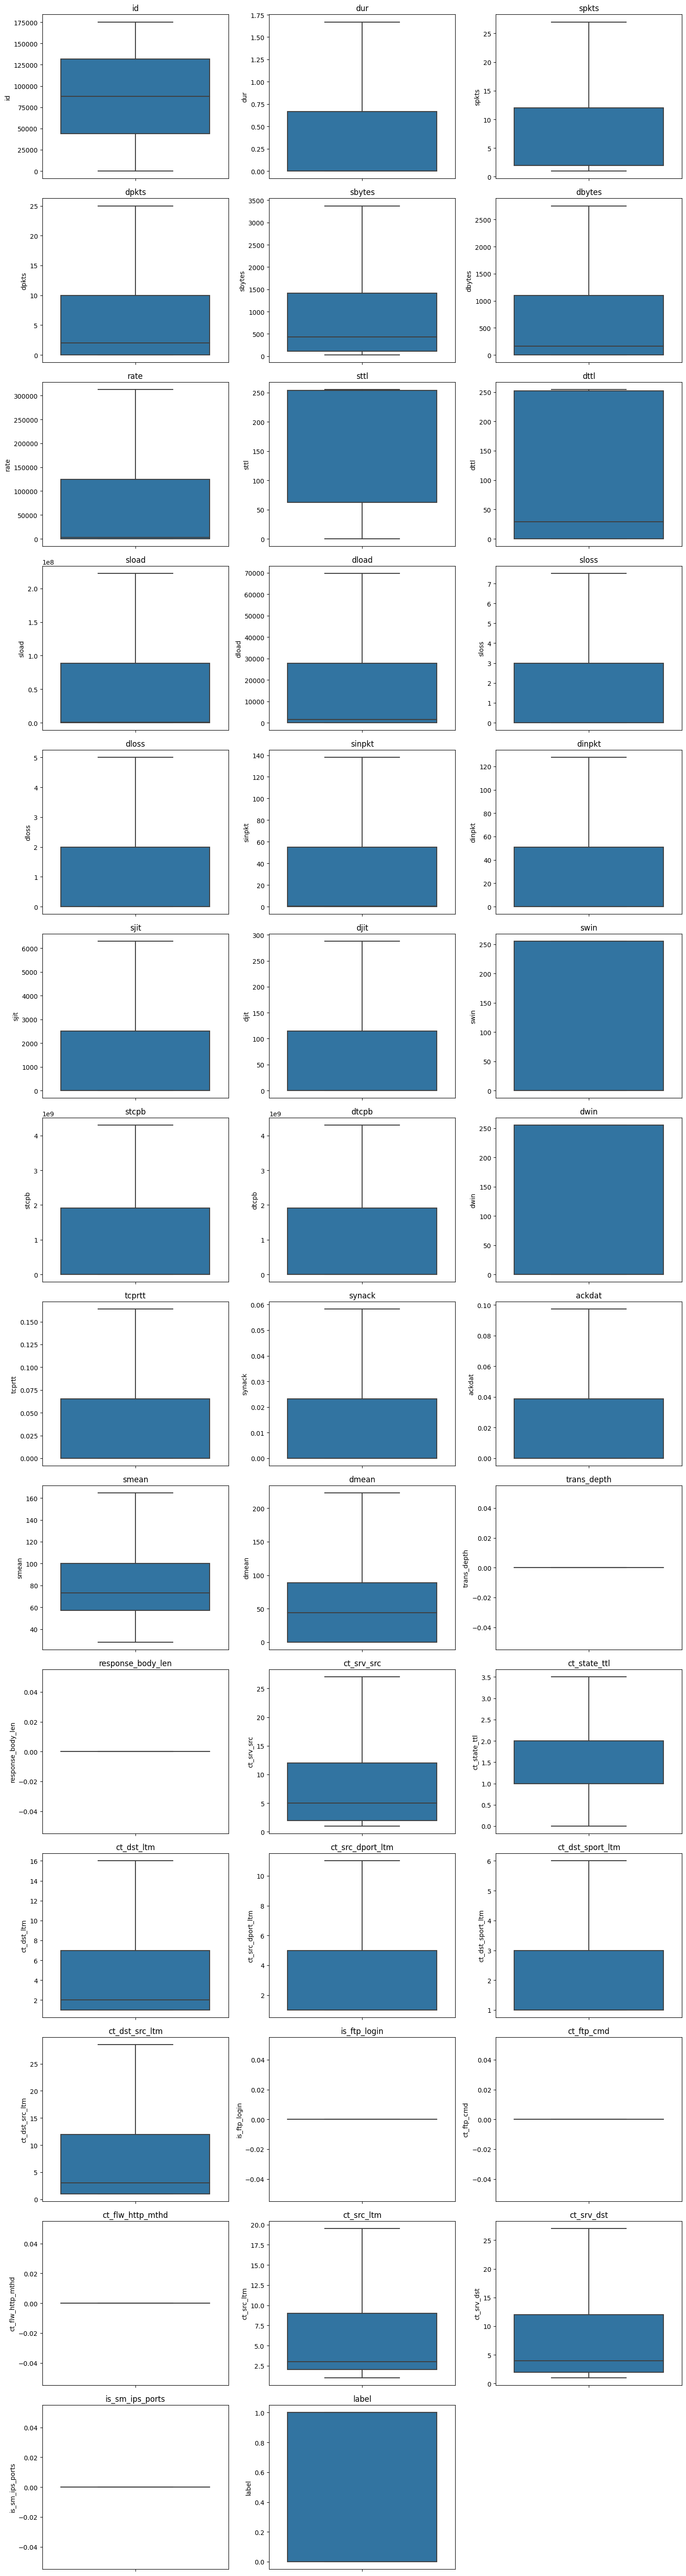

In [12]:
# Define the number of columns per row
import seaborn as sns
num_cols = 3  # Change this based on your dataset
num_rows = -(-len(numerical_cols) // num_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()

# Plot each column
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=train_df[col], ax=axes[i])
    axes[i].set_title(col)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
df=pd.concat([train_df,test_df],axis=0)
x=df.drop('label',axis=1)
y=df.label
X_train , X_test , Y_train , Y_test  = train_test_split(x,y,test_size=.2,random_state=42)

In [13]:
const_cols=[col for col in df.columns if len(np.unique(df[col]))==1]
const_cols

['trans_depth',
 'response_body_len',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_flw_http_mthd',
 'is_sm_ips_ports']

In [14]:
X_train.drop(const_cols,axis=1,inplace=True)
X_test.drop(const_cols,axis=1,inplace=True)

In [19]:
numerical_cols=[col for col in numerical_cols if col not in const_cols]
numerical_cols.remove('label')

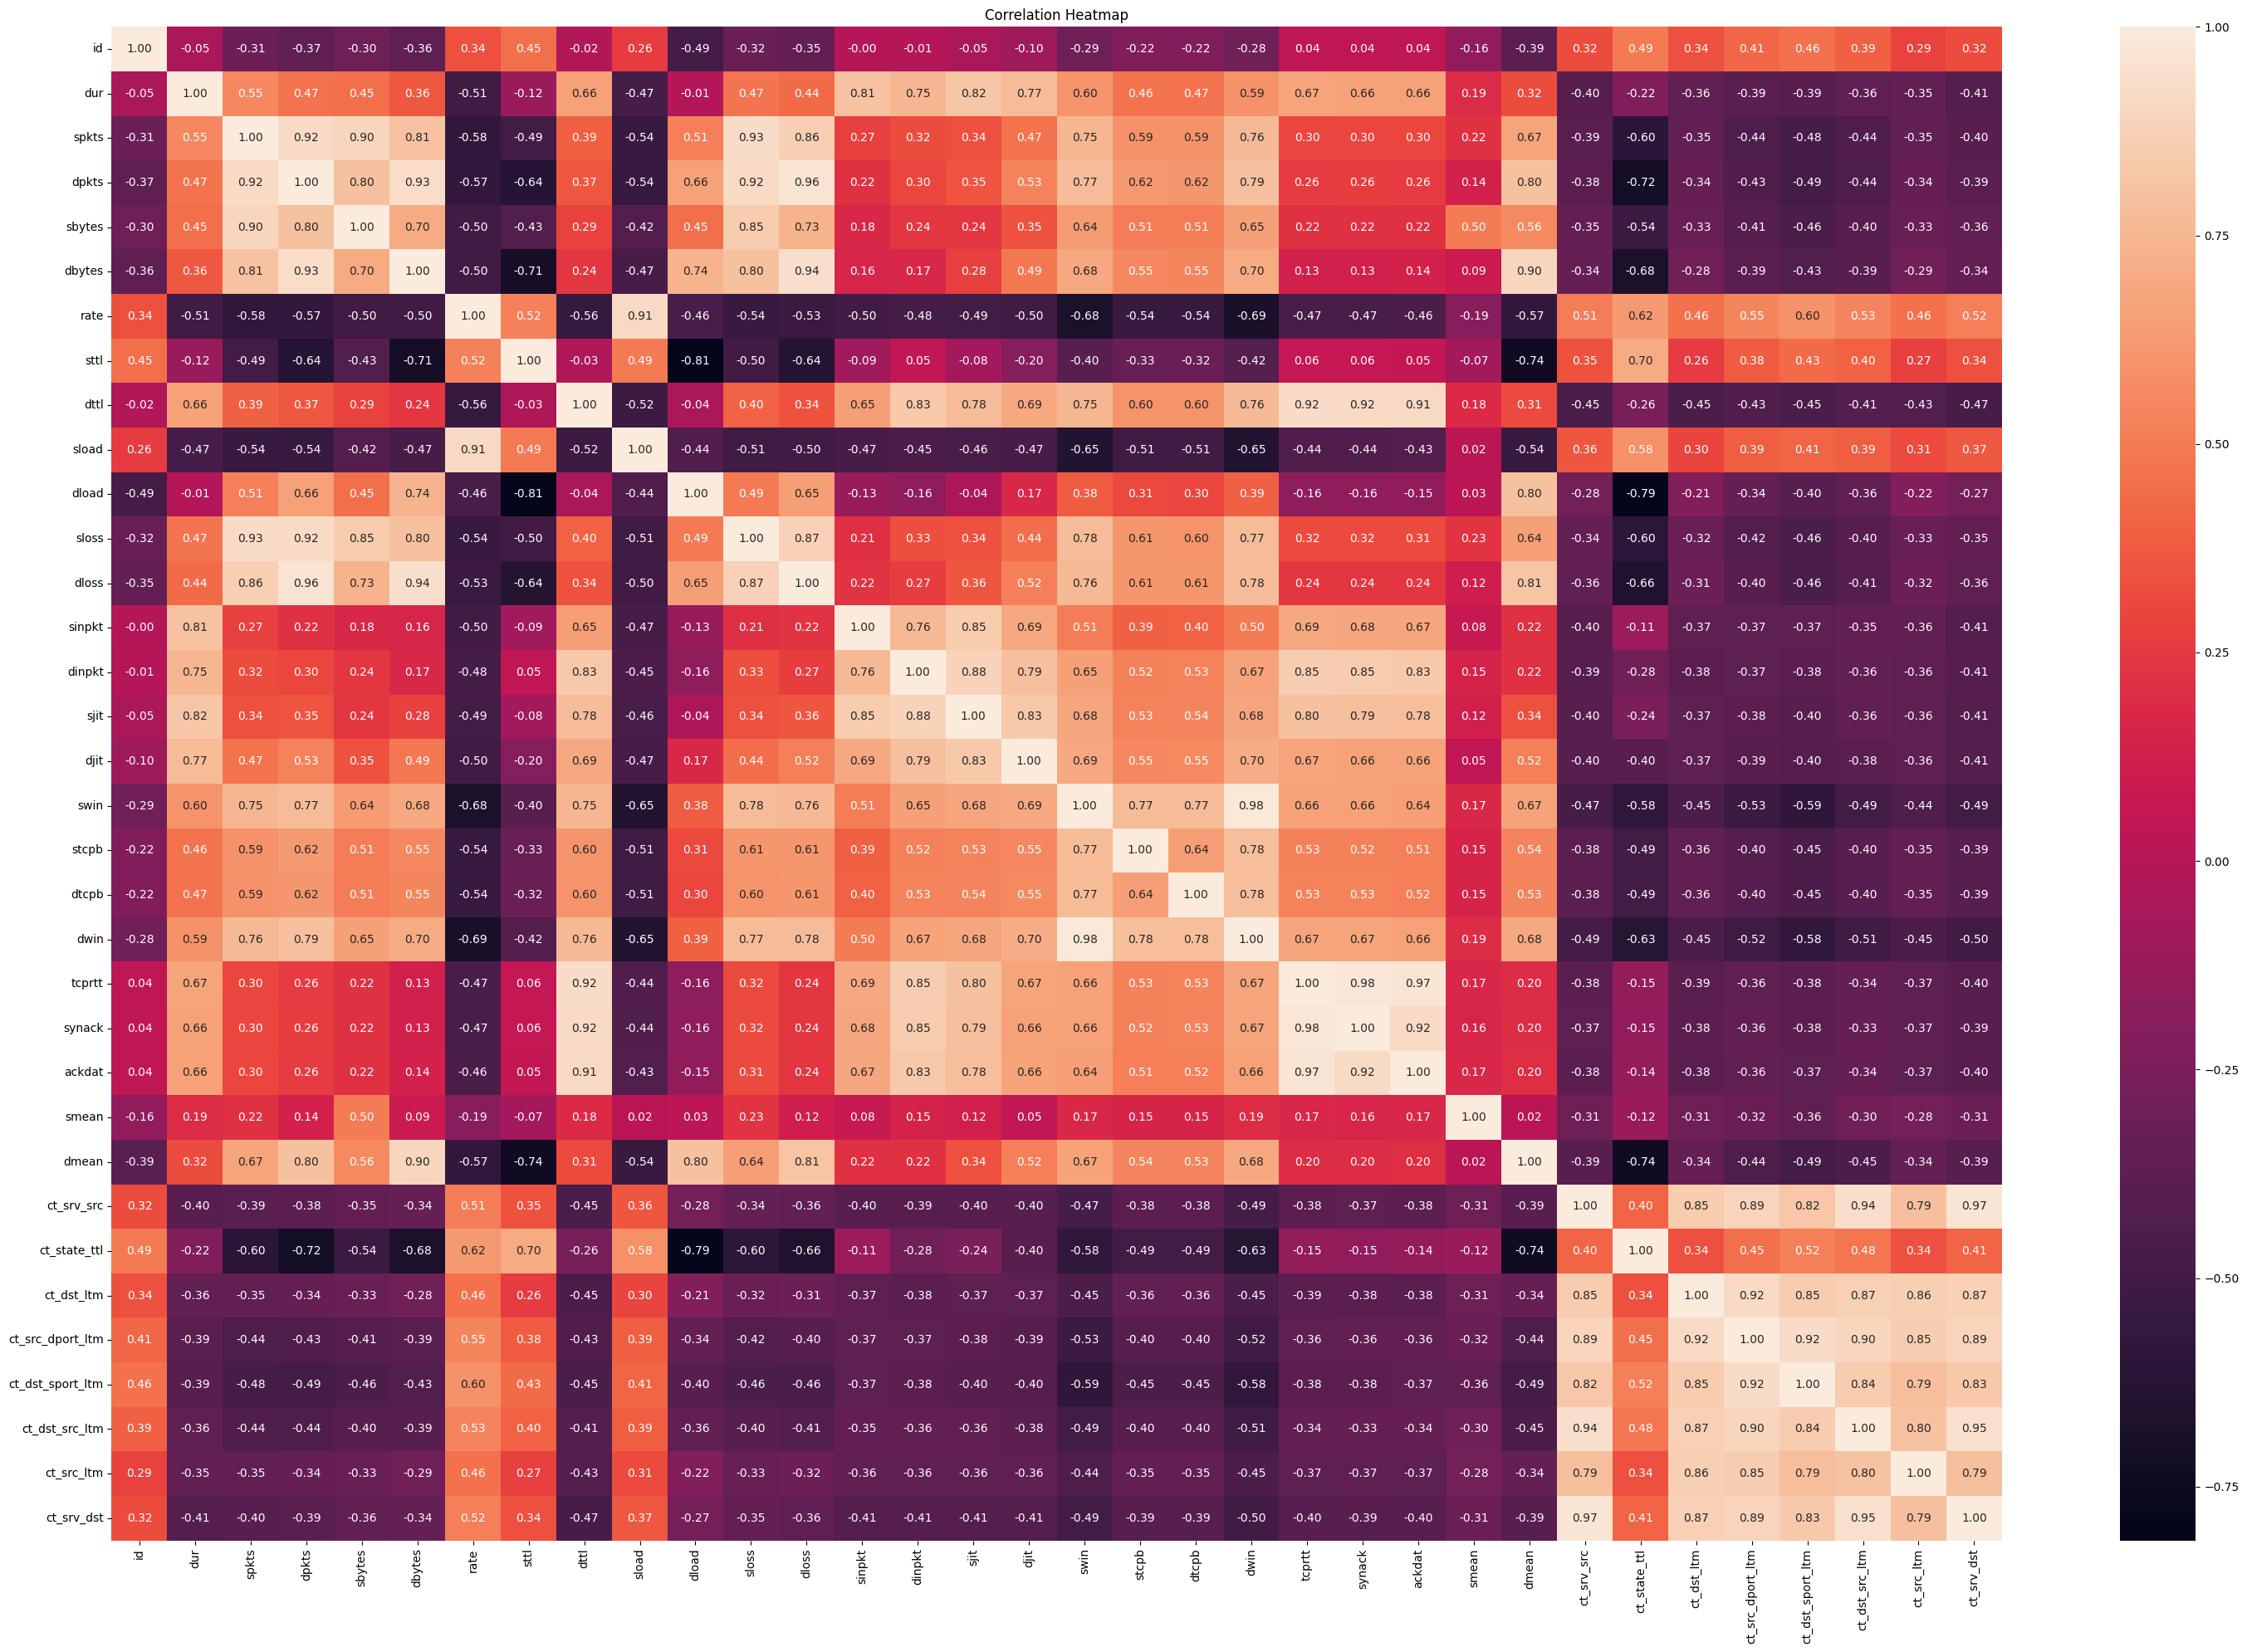

In [22]:
plt.figure(figsize=(30,20))
plt.title('Correlation Heatmap')
sns.heatmap(X_train[numerical_cols].corr(),annot=True,fmt='.2f')
plt.tight_layout()
plt.savefig('heatmap_unsw.jpg',dpi=300,bbox_inches='tight')
plt.show()

In [15]:
df[numerical_cols].corr()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
id,1.000000,-0.050593,-0.313380,-0.367044,-0.304197,-0.361441,0.337718,0.447072,-0.014507,0.258077,...,0.412847,0.454216,0.394109,NaN,NaN,NaN,0.289847,0.321700,NaN,0.490584
dur,-0.050593,1.000000,0.549881,0.464231,0.447014,0.361194,-0.505894,-0.116754,0.656726,-0.474955,...,-0.387091,-0.392822,-0.363236,NaN,NaN,NaN,-0.353858,-0.411486,NaN,-0.035728
spkts,-0.313380,0.549881,1.000000,0.917258,0.896260,0.806927,-0.578331,-0.493450,0.391178,-0.544970,...,-0.440732,-0.480696,-0.437098,NaN,NaN,NaN,-0.353218,-0.394593,NaN,-0.346144
dpkts,-0.367044,0.464231,0.917258,1.000000,0.795637,0.930117,-0.571039,-0.635590,0.367036,-0.538699,...,-0.433068,-0.486299,-0.441030,NaN,NaN,NaN,-0.338160,-0.385203,NaN,-0.411713
sbytes,-0.304197,0.447014,0.896260,0.795637,1.000000,0.696624,-0.501612,-0.430770,0.287159,-0.419355,...,-0.407476,-0.457050,-0.396979,NaN,NaN,NaN,-0.325071,-0.356333,NaN,-0.352903
dbytes,-0.361441,0.361194,0.806927,0.930117,0.696624,1.000000,-0.500086,-0.711325,0.238089,-0.472083,...,-0.386408,-0.428883,-0.393840,NaN,NaN,NaN,-0.288904,-0.340380,NaN,-0.393563
rate,0.337718,-0.505894,-0.578331,-0.571039,-0.501612,-0.500086,1.000000,0.522434,-0.557405,0.910833,...,0.544018,0.594481,0.533026,NaN,NaN,NaN,0.456331,0.515987,NaN,0.441760
sttl,0.447072,-0.116754,-0.493450,-0.635590,-0.430770,-0.711325,0.522434,1.000000,-0.032471,0.493571,...,0.379228,0.433942,0.401454,NaN,NaN,NaN,0.269670,0.338638,NaN,0.624082
dttl,-0.014507,0.656726,0.391178,0.367036,0.287159,0.238089,-0.557405,-0.032471,1.000000,-0.523806,...,-0.432954,-0.453259,-0.412413,NaN,NaN,NaN,-0.428307,-0.469494,NaN,0.019369
sload,0.258077,-0.474955,-0.544970,-0.538699,-0.419355,-0.472083,0.910833,0.493571,-0.523806,1.000000,...,0.383841,0.407400,0.387837,NaN,NaN,NaN,0.313287,0.367000,NaN,0.391367


In [16]:
numerical_cols.remove('label')

In [17]:
corr_features=set()
threshold=0.85
corr_matrix=X_train[numerical_cols].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if i not in corr_features and j not in corr_features:
            if abs(corr_matrix.iloc[i,j])>threshold:
                colname=corr_matrix.columns[i]
                corr_features.add(colname)
print(corr_features)

{'ct_srv_dst', 'dpkts', 'sloss', 'synack', 'ct_dst_sport_ltm', 'sbytes', 'dwin', 'dmean', 'dbytes', 'dloss', 'sjit', 'ct_dst_src_ltm', 'ct_dst_ltm', 'ct_src_ltm', 'ackdat', 'ct_src_dport_ltm', 'sload', 'tcprtt'}


In [18]:
X_train.drop(corr_features,axis=1,inplace=True)
X_test.drop(corr_features,axis=1,inplace=True)

In [19]:
numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object' and col!='state']

In [20]:
categorical_cols

['proto', 'service', 'attack_cat']

In [21]:
X_train.drop('state',axis=1,inplace=True)
X_test.drop('state',axis=1,inplace=True)

In [22]:
from sklearn.preprocessing import OneHotEncoder
Ohe=OneHotEncoder(sparse_output=False,handle_unknown='ignore')
encoded_train=Ohe.fit_transform(X_train[categorical_cols])
encoded_train=pd.DataFrame(encoded_train,columns=Ohe.get_feature_names_out(categorical_cols))
encoded_test=Ohe.transform(X_test[categorical_cols])
encoded_test=pd.DataFrame(encoded_test,columns=Ohe.get_feature_names_out(categorical_cols))
X_train.drop(categorical_cols,axis=1,inplace=True)
X_test.drop(categorical_cols,axis=1,inplace=True)

In [23]:
X_train=X_train.reset_index(drop=True)
encoded_train=encoded_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)
encoded_test=encoded_test.reset_index(drop=True)
X_train=pd.concat([X_train,encoded_train],axis=1)
X_test=pd.concat([X_test,encoded_test],axis=1)
X_train

,id,dur,spkts,rate,sttl,dttl,dload,sinpkt,dinpkt,djit,...,attack_cat_Analysis,attack_cat_Backdoor,attack_cat_DoS,attack_cat_Exploits,attack_cat_Fuzzers,attack_cat_Generic,attack_cat_Normal,attack_cat_Reconnaissance,attack_cat_Shellcode,attack_cat_Worms
0,9460,0.239865,10,62.535175,254,252,7470.868652,26.651667,40.275801,62.099016,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,147135,0.000009,2,111111.107200,254,0,0.000000,0.009000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,33635,1.670161,27,317.027390,31,29,69612.177725,6.682514,6.079203,287.476562,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,110207,0.000000,1,0.000000,0,0,0.000000,137.880240,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5992,0.000003,2,312450.821540,254,0,0.000000,0.003000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206133,119880,0.000005,2,200000.005100,254,0,0.000000,0.005000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
206134,103695,1.670161,24,10.113821,62,252,2804.899658,137.880240,127.632500,287.476562,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
206135,131933,0.000008,2,125000.000300,254,0,0.000000,0.008000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
206136,146868,0.000004,2,250000.000600,254,0,0.000000,0.004000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [24]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train[numerical_cols]=scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols]=scaler.transform(X_test[numerical_cols])

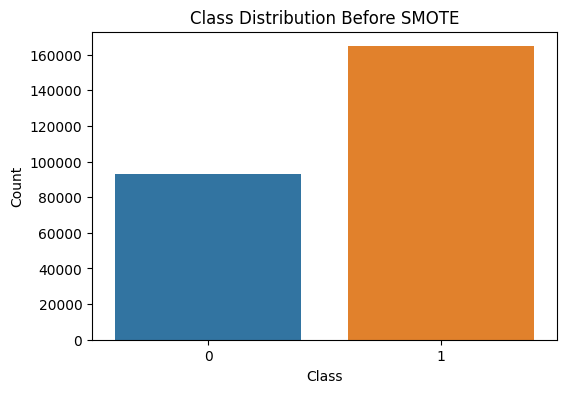

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution before SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'])
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [27]:
from imblearn.over_sampling import SMOTE

Smote = SMOTE(random_state=42,k_neighbors=10)
X_train_smote , y_train_smote = Smote.fit_resample(X_train,Y_train)

print("✅ SMOTE applied successfully!")
print("New Train Dataset Shape:", X_train_smote.shape)


✅ SMOTE applied successfully!
New Train Dataset Shape: (263502, 178)


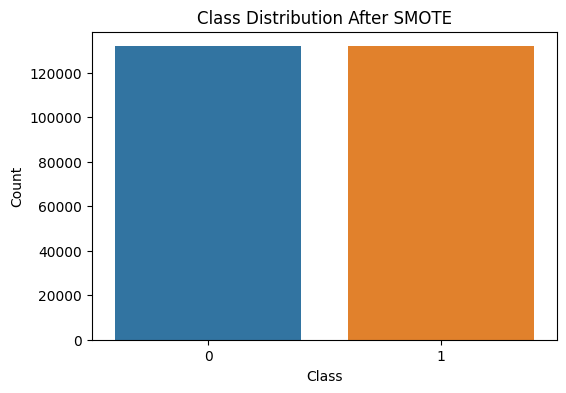

In [28]:
# Plot class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_smote)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [29]:
X_train_smote_df =pd.DataFrame(X_train_smote)
y_train_smote_df = pd.DataFrame(y_train_smote)
X_test_smote_df =pd.DataFrame(X_test)
y_test_smote_df = pd.DataFrame(Y_test)

X_train_smote_df.to_csv("X_train_smote.csv")
y_train_smote_df.to_csv("Y_train_smote.csv")
X_test_smote_df.to_csv("X_test_smote.csv")
y_test_smote_df.to_csv("Y_test_smote.csv")

In [30]:
X_train_smote_df=pd.read_csv(r"/kaggle/working/X_train_smote.csv")
y_train_smote_df=pd.read_csv(r"/kaggle/working/Y_train_smote.csv",)
x_test_smote_df=pd.read_csv(r"/kaggle/working/X_test_smote.csv")
y_test_smote_df=pd.read_csv(r"/kaggle/working/Y_test_smote.csv")

In [31]:
import torch
from transformers import BertTokenizer, BertModel
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load BERT tokenizer and model
MODEL_NAME = "/kaggle/input/bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME,cache_dir="./cache")
model = BertModel.from_pretrained(MODEL_NAME, cache_dir="./cache").to(device)  # Binary classification


Using device: cuda


In [32]:
X_traindf=pd.read_csv("X_train_smote.csv")
y_traindf=pd.read_csv("Y_train_smote.csv")
X_testdf=pd.read_csv("X_test_smote.csv")
y_testdf=pd.read_csv("Y_test_smote.csv")

In [33]:
import pandas as pd

# Assuming X_train and X_test are already split
def convert_to_text(df):
    return df.apply(lambda row: ' '.join([f"{col}: {str(row[col])}" for col in df.columns]), axis=1)

# Convert each row in train and test sets to text
X_train_text = convert_to_text(X_traindf)
X_test_text = convert_to_text(X_testdf)

In [35]:
from transformers import AutoTokenizer, AutoModel
import torch
torch.backends.cuda.matmul.allow_tf32=True
torch.backends.cudnn.allow_tf32=True
model.half()
bert_model=torch.nn.DataParallel(model)
bert_model.to(device)
model.eval()
# Function to extract BERT embeddings
def extract_bert_features(texts, batch_size=1024):
    all_embeddings = []

    # Convert Pandas Series to a list before indexing
    texts = texts.tolist()
    
    with torch.no_grad(),torch.cuda.amp.autocast():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]

        # Tokenize the batch and move tensors to the correct device
            encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
            encoded_input = {key: value.to(device,non_blocking=True) for key, value in encoded_input.items()}
            outputs = bert_model(**encoded_input)

        # ✅ Move tensor to CPU before converting to NumPy
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  
            all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Assuming X_train_text and X_test_text are Pandas Series containing text data
X_train_bert = pd.DataFrame(extract_bert_features(X_train_text))
X_test_bert = pd.DataFrame(extract_bert_features(X_test_text))

# Save to CSV files
X_train_bert.to_csv("X_train_bert.csv", index=False)
X_test_bert.to_csv("X_test_bert.csv", index=False)

# Print shapes of the extracted features
print("Shape of Train Features:", X_train_bert.shape)
print("Shape of Test Features:", X_test_bert.shape)

<ipython-input-35-9afe985c7edc>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(),torch.cuda.amp.autocast():


Shape of Train Features: (263502, 768)
Shape of Test Features: (51535, 768)


In [36]:
y_train_smote_df.drop('Unnamed: 0',axis=1,inplace=True)
y_test_smote_df.drop('Unnamed: 0',axis=1,inplace=True)

In [37]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=100, random_state=42,n_iter_no_change=10,batch_size=1024)
mlp.fit(X_train_bert, y_train_smote_df)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=1024, hidden_layer_sizes=(128, 64), max_iter=100,
              random_state=42)

In [38]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
# Make Predictions
y_pred = mlp.predict(X_test_bert)
accuracy_score(y_test_smote_df, y_pred)

0.8659745803822645

In [39]:
print(classification_report(y_test_smote_df,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.94      0.84     18613
           1       0.96      0.82      0.89     32922

    accuracy                           0.87     51535
   macro avg       0.86      0.88      0.86     51535
weighted avg       0.88      0.87      0.87     51535



<Axes: title={'center': 'Confusion Matrix for MLP'}>

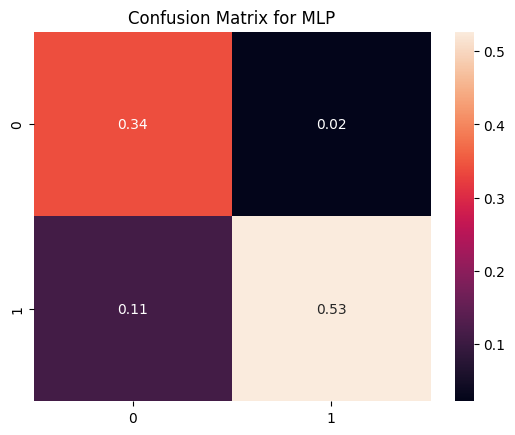

In [40]:
plt.title("Confusion Matrix for MLP")
sns.heatmap(confusion_matrix(y_test_smote_df,y_pred)/len(y_test_smote_df),annot=True,fmt=".2f")

In [41]:
from sklearn.metrics import roc_curve,auc
y_score=mlp.predict_proba(X_test_bert)[:,1]
fpr,tpr,_=roc_curve(y_test_smote_df,y_pred)
roc_auc=auc(fpr,tpr)

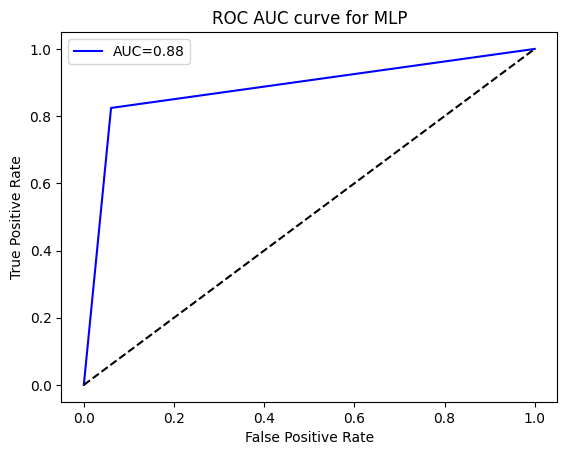

In [42]:
plt.title("ROC AUC curve for MLP")
plt.plot(fpr,tpr,'b-',label=f"AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()